# Cryptocrash

In [ ]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import MultivariateGaussian, DSMMultivariateGaussian
from utils.find_cp import find_cp

from sklearn import preprocessing

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## Import data

In [ ]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/Cryptocrash')
FILE_PATH_1 = os.path.join(DATA_PATH,'Cryptocrash/FTT-USD.csv')
FILE_PATH_2 = os.path.join(DATA_PATH,'Cryptocrash/BTC-USD.csv')

In [3]:
start_date = '2022-10-01'
end_date = '2023-01-01'

In [4]:
ftx = pd.read_csv(FILE_PATH_1)
ftx['Date'] = pd.to_datetime(ftx['Date'])
ftx.sort_values(by='Date', inplace=True)
ftx = ftx[(ftx['Date']>start_date)& (ftx['Date']<end_date)]

In [5]:
btc = pd.read_csv(FILE_PATH_2)
btc['Date'] = pd.to_datetime(btc['Date'])
btc.sort_values(by='Date', inplace=True)
btc = btc[(btc['Date']>start_date) & (btc['Date']<end_date)]

In [6]:
df = pd.merge(ftx[['Date','Open']],btc[['Date','Open']], on='Date')
df.columns =['date', 'ftx', 'btc']

In [7]:
data = df[['ftx','btc']].values
dates = df['date']

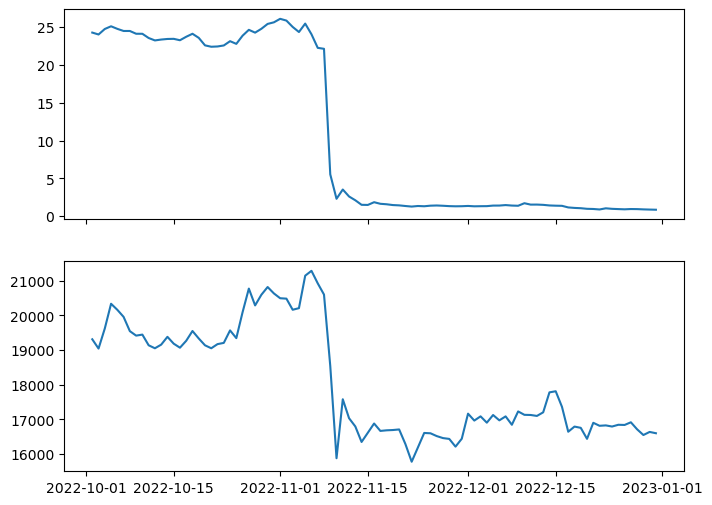

In [8]:
fig ,ax = plt.subplots(2, figsize=(8,6),sharex=True)
ax[0].plot(dates,data[:,0])
ax[1].plot(dates,data[:,1])

In [9]:
data_scaled = preprocessing.StandardScaler().fit_transform(data)

## Define functions needed for the method: $m$, $\nabla m$

In [10]:
def m(x):
    m = np.eye(2)
    m[0,0] = (1+x[0]**2)**(-1/2)
    m[1,1] = (1+x[1]**2)**(-1/2)
    return m

def grad_m(x):
    m1 = np.zeros((2,2))
    m1[0,0] = -x[0]/((1+x[0]**2)**(3/2))
    m2 = np.zeros((2,2))
    m2[1,1] = -x[1]/((1+x[1]**2)**(3/2))
    return np.concatenate((np.asarray([m1]),np.asarray([m2])),axis=0)

## Prior parameters and $\omega$

In [11]:
omega = 0.1

mean1_mu0 = 0
var1_mu0 = 1
mean2_mu0 = 0
var2_mu0 = 1

mean1_Sigma0 = 5
var1_Sigma0 = 2
mean2_Sigma0 = 5
var2_Sigma0 = 2


mu0 = np.asarray([[mean1_mu0/var1_mu0], [1/var1_mu0],[mean2_mu0/var2_mu0], [1/var2_mu0]])

Sigma0 = np.eye(4)

Sigma0[0,0] = mean1_Sigma0/var1_Sigma0
Sigma0[1,1] = 1/var1_Sigma0
Sigma0[2,2] = mean2_Sigma0/var2_Sigma0
Sigma0[3,3] = 1/var2_Sigma0

## Initialize model and CP prior

In [12]:
model_DSM = DSMMultivariateGaussian(data_scaled, m ,grad_m, omega, mu0, Sigma0, d=2, b = 40)
model_standard = MultivariateGaussian(d=2)

In [13]:
hazard = ConstantHazard(50)

## Run BOCD algorithm

In [14]:
%%time
np.random.seed(100)
R_DSM  = bocpd(data_scaled, hazard, model_DSM, K=50, verbose=True)

CPU times: user 7.91 s, sys: 0 ns, total: 7.91 s
Wall time: 7.91 s


In [15]:
%%time
np.random.seed(100)
R_standard = bocpd(data_scaled, hazard, model_standard, K=50, verbose=True)

CPU times: user 328 ms, sys: 15.6 ms, total: 344 ms
Wall time: 328 ms


## Plot

/tmp/ipykernel_5856/2428704628.py:43: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


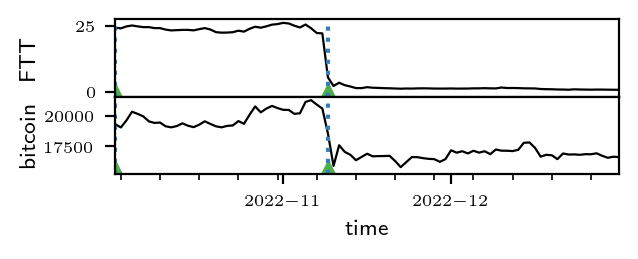

In [16]:
FILE_NAME = 'Cryptocrash_no_RL.pdf'

cps_DSM = find_cp(R_DSM)
cps_standard= find_cp(R_standard)

T = len(dates)
cp_color = CB_color_cycle[0]

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

x_lims = mdates.date2num([dates.values[0],dates.values[-1]])
with plt.rc_context(bundles.icml2022(ncols=2)):

    fig, ax = plt.subplots(2, 1, sharex = True, dpi = 200)
    ax[0].plot(dates,data[:,0],color='black',lw=0.8)
    y_lims0 = ax[0].get_ylim()

    ax[1].plot(dates,data[:,1],color='black',lw=0.8)
    y_lims1 = ax[1].get_ylim()
    
    ax[0].set_xlim([x_lims[0],x_lims[1]])
    
    for cp in cps_DSM:
        ax[0].axvline(dates[cp], c=CB_color_cycle[0], ls='dotted', lw=1.5)
        ax[1].axvline(dates[cp], c=CB_color_cycle[0], ls='dotted', lw=1.5)
        
    for cp in cps_standard:
        ax[0].scatter(dates[cp], y_lims0[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
        ax[1].scatter(dates[cp], y_lims1[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
    
    ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax[0].xaxis.set_major_locator(mdates.MonthLocator())
    
    ax[0].set_ylabel('FTT')
    ax[1].set_ylabel('bitcoin')
    
    ax[1].set_xlabel('time')
    
    ax[0].yaxis.set_label_coords(-0.15,0.5)
    ax[1].yaxis.set_label_coords(-0.15,0.5)
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")
    

/tmp/ipykernel_5856/2352145311.py:51: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


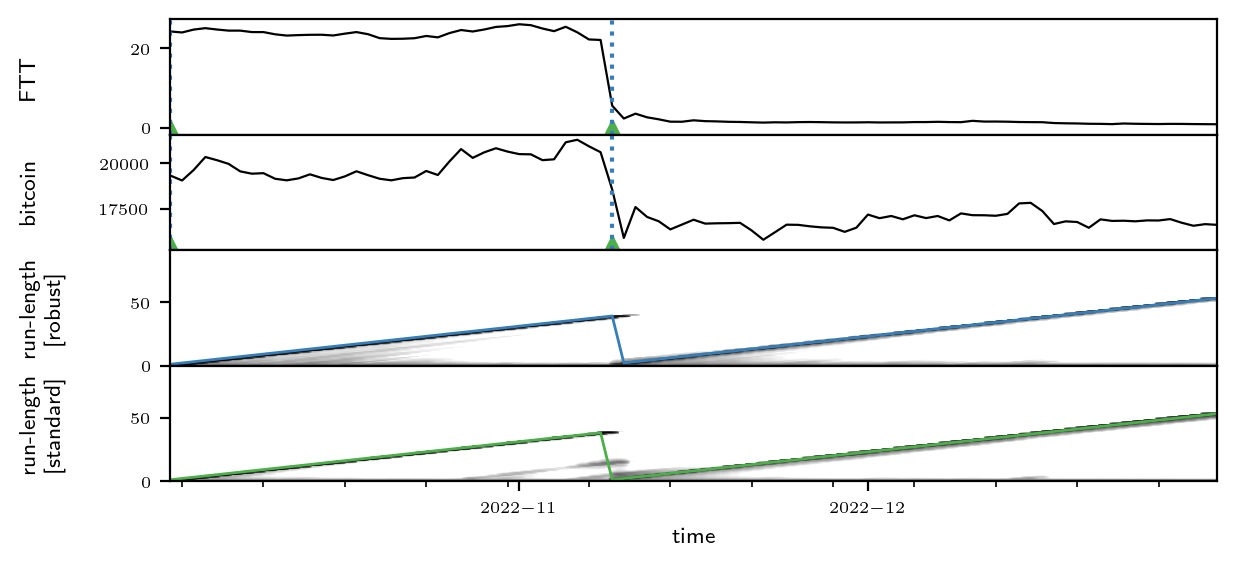

In [17]:
FILE_NAME = 'Cryptocrash.png'
T = len(dates)
cp_color = CB_color_cycle[0]

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

x_lims = mdates.date2num([dates.values[0],dates.values[-1]])
with plt.rc_context(bundles.icml2022(column='full', ncols=2, nrows=1)):

    fig, ax = plt.subplots(4, 1, sharex = True, dpi = 200,figsize=(6.75,3))
    ax[0].plot(dates,data[:,0],color='black',lw=0.8)
    y_lims0 = ax[0].get_ylim()

    ax[1].plot(dates,data[:,1],color='black',lw=0.8)
    y_lims1 = ax[1].get_ylim()

    ax[2].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r',
                 norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[2].plot(dates,np.argmax(R_DSM[1:],axis=1), c=CB_color_cycle[0],lw=1)
    
    ax[3].imshow(np.rot90(R_standard), aspect='auto', cmap='gray_r',
                 norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[3].plot(dates,np.argmax(R_standard[1:],axis=1), c=CB_color_cycle[2],lw=1)

    
    for cp in cps_DSM:
        ax[0].axvline(dates[cp], c=CB_color_cycle[0], ls='dotted', lw=1.5)
        ax[1].axvline(dates[cp], c=CB_color_cycle[0], ls='dotted', lw=1.5)
        
    for cp in cps_standard:
        ax[0].scatter(dates[cp], y_lims0[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
        ax[1].scatter(dates[cp], y_lims1[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
    
    ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax[0].xaxis.set_major_locator(mdates.MonthLocator())
    
    ax[0].set_ylabel('FTT')
    ax[1].set_ylabel('bitcoin')
    ax[2].set_ylabel('run-length \n [robust]')
    ax[3].set_ylabel('run-length \n [standard]')
    
    ax[3].set_xlabel('time')
    
    ax[0].yaxis.set_label_coords(-0.125,0.5)
    ax[1].yaxis.set_label_coords(-0.125,0.5)
    ax[2].yaxis.set_label_coords(-0.1,0.5)
    ax[3].yaxis.set_label_coords(-0.1,0.5)
    

    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="png", bbox_inches= "tight")